<center><h1> Problem2 - CNN on MNIST </h1><center>

### Import the required packages

In [1]:
import tensorflow as tf

#To check if tensorflow can access the gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

Found GPU at: /device:GPU:0


### Load MNIST Data

In [29]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


### Check the train-valid-test data size

In [3]:
print("Train-set:\t\t{}".format(len(data.train.labels)))
print("Test-set:\t\t{}".format(len(data.test.labels)))
print("Validation-set:\t\t{}".format(len(data.validation.labels)))

Train-set:		55000
Test-set:		10000
Validation-set:		5000


### Initalization of the placeholder variables

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')
x_image = tf.reshape(x, [-1, 28, 28, 1])

y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Functions to create basic CNN layers

In [0]:
#Create convolution layer
def conv_layer(input, num_input_channels, filter_size, num_filters, name):
    
    with tf.variable_scope(name) as scope:
        
        #Filter-shape
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Weights and Biases
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.02))
        #weights = tf.Variable(tf.constant(0, shape))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
        layer += biases
        
        return layer, weights

#Create pool layer      
def pool_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        return layer
      
#Create ReLU Activation Layer
def relu_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
     
        return layer

#Create Fully Connected Layer
def fc_layer(input, num_inputs, num_outputs, name):
    
    with tf.variable_scope(name) as scope:

        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.02))
        biases = tf.Variable(tf.constant(0.02, shape=[num_outputs]))
        
        layer = tf.matmul(input, weights) + biases
        
        return layer

###  Convolutional Neural Network - Architecture for Classification

In [0]:
# Convolution 1
conv1, weights_conv1 = conv_layer(input=x_image, num_input_channels=1, filter_size=7, num_filters=8, name ="conv1")
pool1 = pool_layer(conv1, name="pool1")
relu1 = relu_layer(pool1, name="relu1")

# Convolution 2
conv2, weights_conv2 = conv_layer(input=relu1, num_input_channels=8, filter_size=7, num_filters=16, name= "conv2")
pool2 = pool_layer(conv2, name="pool2")
relu2 = relu_layer(pool2, name="relu2")

# Flatten Layer
num_features = relu2.get_shape()[1:4].num_elements()
flat = tf.reshape(relu2, [-1, num_features])

# Fully-Connected Layer 1
fc1 = fc_layer(flat, num_inputs=num_features, num_outputs=128, name="fc1")
relu3 = relu_layer(fc1, name="relu3")

# Fully-Connected Layer 2
fc2 = fc_layer(input=relu3, num_inputs=128, num_outputs=10, name="fc2")

### Output Parameterization - Softmax Function

In [0]:
# Use Softmax function to parameterize the output
with tf.variable_scope("Softmax"):
    y_pred = tf.nn.softmax(fc2)
    y_pred_cls = tf.argmax(y_pred, dimension=1)

### Loss Calculation - Cross Entropy Function

In [11]:
# Use Cross entropy function to calculate loss
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Optimization with Stochastic Gradient Descent Optimizer

In [0]:
# Use SGD Optimizer
with tf.name_scope("optimizer"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(cost)

### Accuracy Calculation

In [0]:
# Accuracy
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Addition of result metrics to summary

In [0]:
# Initialize the FileWriter
writer = tf.summary.FileWriter("Training_FileWriter/")
writer1 = tf.summary.FileWriter("Validation_FileWriter/")

# Add the loss and accuracy to summary
tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)
merged_summary = tf.summary.merge_all()

### Set the n(epochs) and batch size

In [0]:
num_epochs = 10
batch_size = 64

### TensorFlow Session - Start training for the specified n(epochs)




In [26]:
train_l = []
valid_l = []
epoch_n = []

with tf.Session() as sess:
   
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    
    for epoch in range(num_epochs):
        
        start_time = time.time()
        train_accuracy = 0
        train_loss     = 0
        
        for batch in range(0, int(len(data.train.labels)/batch_size)):
            
            # 
            x_batch, y_true_batch = data.train.next_batch(batch_size)
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            
            # Runnig optimizer on each batch
            sess.run(optimizer, feed_dict=feed_dict_train)
            
            # Accuracy and loss Calculation per batch
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
            train_loss     += sess.run(cost, feed_dict=feed_dict_train)
            
            # Summary generation on current batch
            summ = sess.run(merged_summary, feed_dict=feed_dict_train)
            writer.add_summary(summ, epoch*int(len(data.train.labels)/batch_size) + batch)
        
          
        train_accuracy /= int(len(data.train.labels)/batch_size)
        train_loss /= int(len(data.train.labels)/batch_size)
        
        # Validating the model on validation set
        summ, vali_accuracy = sess.run([merged_summary, accuracy], feed_dict={x:data.validation.images, y_true:data.validation.labels})
        summ, vali_loss = sess.run([merged_summary, cost], feed_dict={x:data.validation.images, y_true:data.validation.labels})
        writer1.add_summary(summ, epoch)
        
        end_time = time.time()
        
        print("\n Epoch "+str(epoch+1)+":Time taken "+str(int(end_time-start_time))+" seconds")
        
        #To get Accuracy metrics
        '''
        print("\t Accuracy:")
        print("\t-------")
        print ("\t Train Accuracy     :\t{}".format(train_accuracy))
        print ("\t Validation Accuracy:\t{}".format(vali_accuracy))
        
        '''
        #To get Loss metrics
        print("\t Loss:")
        print("\t-------")
        print ("\t Train Loss     :\t{}".format(train_loss))
        print ("\t Validation Loss:\t{}".format(vali_loss))
        
        train_l.append(float(train_loss))
        valid_l.append(float(vali_loss))
        epoch_n.append(int(epoch+1))
            
        #To plot train and valid error after each epoch
        '''
        plt.plot(int(epoch+1), round(float(train_loss),5), label="trainloss", color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
        plt.plot(int(epoch+1), round(float(vali_loss),5), label="valloss", color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
        plt.xlabel('Epoch_Number')
        plt.ylabel('Error')
        plt.title('TrainError VS ValidError')
        #plt.savefig('TrainerrorVSValerror.png', bbox_inches='tight')
        plt.show() 
        
        '''
        


 Epoch 1:Time taken 9 seconds
	 Loss:
	-------
	 Train Loss     :	2.3024016256521134
	 Validation Loss:	2.302992343902588

 Epoch 2:Time taken 9 seconds
	 Loss:
	-------
	 Train Loss     :	2.3015936830962493
	 Validation Loss:	2.3023083209991455

 Epoch 3:Time taken 9 seconds
	 Loss:
	-------
	 Train Loss     :	2.301015947694967
	 Validation Loss:	2.301619052886963

 Epoch 4:Time taken 9 seconds
	 Loss:
	-------
	 Train Loss     :	2.3002915016014445
	 Validation Loss:	2.30094051361084

 Epoch 5:Time taken 9 seconds
	 Loss:
	-------
	 Train Loss     :	2.299748022703408
	 Validation Loss:	2.3002631664276123

 Epoch 6:Time taken 8 seconds
	 Loss:
	-------
	 Train Loss     :	2.299048087927182
	 Validation Loss:	2.2995951175689697

 Epoch 7:Time taken 8 seconds
	 Loss:
	-------
	 Train Loss     :	2.298403104886465
	 Validation Loss:	2.298941135406494

 Epoch 8:Time taken 8 seconds
	 Loss:
	-------
	 Train Loss     :	2.2978346661444453
	 Validation Loss:	2.2982656955718994

 Epoch 9:Time ta

### Plot train and validation error per epoch

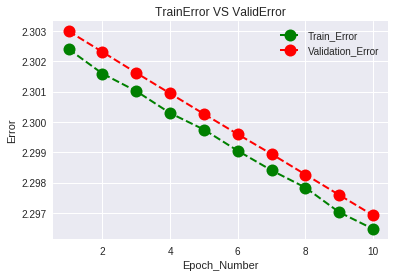

In [28]:
#Plot the train and valid error at end of each epoch

p1=plt.plot(epoch_n, train_l, label="trainloss", color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
p2=plt.plot(epoch_n, valid_l, label="valloss", color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('Epoch_Number')
plt.ylabel('Error')
plt.title('TrainError VS ValidError')
plt.legend((p1[0], p2[0]), ('Train_Error', 'Validation_Error'))
#plt.savefig('TrainerrorVSValerror.png', bbox_inches='tight')
plt.show() 
